# Pre-Equilibrium Maximazation of Yield #

In [1]:
# make sure jupyter path is correct for loading local moudules
import sys
# path to steric_simulator module relative to notebook
sys.path.append("../../../")
import copy

In [2]:
from steric_free_simulator import ReactionNetwork, VectorizedRxnNet_Exp, VecSim, Optimizer, EquilibriumSolver,OptimizerExp
import networkx as nx
import torch
from torch import DoubleTensor as Tensor
import numpy as np

EnergyExplorer Module is not available. Check Rosetta installation. <ipykernel.iostream.OutStream object at 0x14d5ef524518>


We'll start with the AP2 complex that we've worked with before. Pairwise $\Delta Gs$ were derived from the PDB structures via Rossetta

In [3]:
base_input = '../../input_files/ap2_dG_trap.pwr'
rn = ReactionNetwork(base_input, one_step=True)
rn.resolve_tree()


['default_assoc', 1.0]
['homo_rates', True]
['A']
100.0
['B']
100.0
['M']
100.0
['S']
100.0
Parsing rule...
SPLIT_01:  ['A(a)+B(b)', 'A(a!1).B(a!1)']
['A', 'B', '']
GGGGGGGGGgg
Parsing rule...
SPLIT_01:  ['A(b)+M(a)', 'A(b!1).M(a!1)']
['A', 'M', '']
GGGGGGGGGgg
Parsing rule...
SPLIT_01:  ['A(c)+S(a)', 'A(c!1).S(a!1)']
['A', 'S', '']
GGGGGGGGGgg
Parsing rule...
SPLIT_01:  ['B(b)+M(b)', 'B(b!1).M(b!1)']
['B', 'M', '']
GGGGGGGGGgg
Parsing rule...
SPLIT_01:  ['B(b)+S(b)', 'B(b!1).S(b!1)']
['B', 'S', '']
GGGGGGGGGgg
Parsing rule...
SPLIT_01:  ['M(c)+S(b)', 'M(c!1).S(b!1)']
['M', 'S', '']
GGGGGGGGGgg
Node-1 :  (0, {'struct': <networkx.classes.graph.Graph object at 0x14d55a89e6d8>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1})
Node-2 :  (0, {'struct': <networkx.classes.graph.Graph object at 0x14d55a89e6d8>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1})
-----
{'A'}
{'A'}
set()
Steric hindrance detected
Node-1 :  (0, {'struct': <networkx.classes.graph.Graph obj

In [4]:
print(rn.dG_is_param)

False


In [5]:
uid_dict = {}
sys.path.append("../../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    #print(n)
    #print(rn.network.nodes()[n])
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_dict[(n,k)] = uid

print(uid_dict)

{(0, 4): 0, (0, 5): 1, (0, 6): 2, (0, 9): 16, (0, 10): 17, (0, 12): 18, (0, 14): 21, (1, 4): 0, (1, 7): 3, (1, 8): 4, (1, 9): 5, (1, 10): 6, (1, 13): 19, (1, 14): 20, (2, 5): 1, (2, 7): 3, (2, 11): 7, (2, 9): 8, (2, 12): 9, (2, 13): 10, (2, 14): 11, (3, 6): 2, (3, 8): 4, (3, 11): 7, (3, 10): 12, (3, 12): 13, (3, 13): 14, (3, 14): 15, (4, 9): 8, (4, 10): 12, (5, 9): 5, (5, 12): 13, (6, 10): 6, (6, 12): 9, (7, 13): 14, (7, 9): 16, (8, 13): 10, (8, 10): 17, (9, 14): 15, (10, 14): 11, (11, 12): 18, (11, 13): 19, (12, 14): 20, (13, 14): 21}


In [6]:
#Do modifications here
#Changing Initial Conditions
import networkx as nx
#Changin k_on
new_kon = torch.zeros([rn._rxn_count], requires_grad=True).double()
new_kon = new_kon + Tensor([2]*np.array(1e0))
# new_kon = new_kon +torch.rand(len(new_kon))*4

#Random initial condition
#Latest
# new_kon = new_kon + Tensor([1.0784531126282055, 1.029458105931473, 1.1269561454873085, 1.1016504619786531, 1.1962540960808816, 12.733516534843671, 13.127248934123227, 1.0685841067754172, 12.268238406610628, 11.377777346624722, 3.567418136298749, 5.936616399850786, 13.945665881026535, 13.370150974891361, 11.895765670366242, 4.970355439491927, 11.479711161807957, 2.391746953140913, 13.204855105632266, 11.736181219089554, 4.7102150063254795, 7.89012439713287])


# new_kon = new_kon + Tensor([0.5742, 0.5904, 0.5740, 0.5455, 0.5514, 7.5604, 7.9476, 0.5958, 7.0857,
#         6.1911, 5.7815, 4.7904, 8.7658, 8.1895, 6.7626, 3.8649, 6.3190, 1.3492,
#         8.0216, 6.5788, 3.7168, 6.6780])

# new_kon = new_kon + Tensor([3.875147930751502, 3.633157460430131, 3.07085193445574, 0.9518820841788759, 1.0494634790517816, 3.875147930751502, 3.875147930751502, 1.0627547697426531, 3.633157460430131, 3.633157460430131, 1.0627547697426531, 3.633157460430131, 3.07085193445574, 3.07085193445574, 1.0627547697426531, 3.07085193445574, 3.875147930751502, 3.875147930751502, 3.633157460430131, 1.0494634790517816, 3.875147930751502, 3.875147930751502])


#Starting condition for HomoRates
# rates = [0.2498580000880769, 1.5458277554618909, 1.3286185272052629]
# rates=[5,5,5]
# rates=[0.8469241906100582, 2.0549138907600244, 7.962836081464261]
# rates=[0.6910176821168917, 1.893485325644041, 8.187479054602493]

# rates = [0.7638575677886703, 1.2275762212163108, 1.2292556662570815] # Current
# rates = [0.3667160530555285, 4.056637284043357, 4.197374196441568]
# rates= [0.6090738370299691, 2.0618771938391056, 8.36260499321765]
# rates = [0.31993640267233014, 3.439671796780782, 3.669072000528544]
# rates = [0.7754529778993657, 2.7661023329487895, 5.638537667297305]
# rates=[0.1668, 2.8192, 2.8560]
rates=[0.29646059227830807, 3.8221716863515653, 3.5559205371359406]
counter=0
for k,v in rn.rxn_class.items():
    for rid in v:
        new_kon[v] = rates[counter]
    counter+=1



update_kon_dict = {}
for edge in rn.network.edges:
    print(rn.network.get_edge_data(edge[0],edge[1]))
    update_kon_dict[edge] = new_kon[uid_dict[edge]]

nx.set_edge_attributes(rn.network,update_kon_dict,'k_on')

# for edge in rn.network.edges:
#     print(rn.network.get_edge_data(edge[0],edge[1]))
vec_rn = VectorizedRxnNet_Exp(rn, dev='cpu')
print(vec_rn.kon)

#Changing initial concentrations

{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-15.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-15.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-15.], dtype=torch.float64), 'uid': 2}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-30.], dtype=torch.float64), 'uid': 16}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-30.], dtype=torch.float64), 'uid': 17}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-30.], dtype=torch.float64), 'uid': 18}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-45.], dtype=torch.float64), 'uid': 21}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-15.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-15.], dtype=torch.float64), 'uid': 3}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-15.], dtype=torch.float64), 'uid': 4}
{'k_on

## The Equilibrium Solution ##
First we will find the equilibrium solution for this system.

In [7]:
print(rn.dG_is_param)
print(vec_rn.dG_is_param)
# print(rn.ddG_fluc)

False
False


## Using the optimizer with a 1 second simulation runtime ##

In [8]:
# learn_rate=[1e-3,1e-3]
learn_rate=1e-3
momentum=0.2
runtime=10

files_range=[100,500,1000,5000,10000]
yield_thresh=0.8
yield_min=0.7

In [9]:

vec_rn.reset(reset_params=True)
optim = OptimizerExp(reaction_network=vec_rn,
                  sim_runtime=runtime,
                  optim_iterations=100,
                  learning_rate=learn_rate,
                  device='cpu',method="Adam",reg_penalty=1000000,mom=momentum)


Using CPU


## Conc based optimization


In [10]:
# files_range=[50,80,100,120,150]
# optim.rn.update_reaction_net(rn)
# optim.optimize_wrt_conc(conc_scale=1e-1,conc_thresh=1e-1,mod_bool=True,mod_factor=10,max_thresh=1e2,max_yield=0,yield_species=14,conc_files_pref="ConcProfile_Time_HomoRates_",conc_files_range=files_range,time_threshmax=1)

### TIme based optimization

In [11]:
# optim.rn.update_reaction_net(rn)
# optim.optimize_wrt_time(conc_scale=1e-1,conc_thresh=1e-1,mod_bool=True,mod_factor=10,max_thresh=1e2,max_yield=0,yield_species=14,
#                         conc_file="ConcProfile_Time_1000.0uM",time_threshmin=1e-3,time_threshmax=2e-3)

In [12]:
optim.optimizer.load_state_dict(torch.load("Opt_state_01"))

In [13]:
# files_range=[10,50,100,500,1000,5000]
# files_range=[10,50,100,1000]

optim.rn.update_reaction_net(rn)
optim.optimize_wrt_conc_beta(conc_scale=1e-1,conc_thresh=1e-1,mod_bool=True,mod_factor=10,max_thresh=1e2,max_yield=0,yield_species=14,
                        conc_files_pref="dG_trap/ConcProfile_Time_HomoRates_",conc_files_range=files_range,yield_threshmin=yield_min,yield_threshmax=yield_thresh)

Total number of batches:  5
Optimizer State: <bound method Optimizer.state_dict of RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.005
    momentum: 0.0
    weight_decay: 0
)>
Using CPU
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 100.000000,100.000000,100.000000,100.000000 -------------------------------
Start of simulation: memory Used:  8.0
Next time:  tensor(0.0421, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  100.0uM was 78.9%
SSE at 100.000000 :  0.116696
Exp Yield:  tensor(0.8012, dtype=torch.float64) Sim Yield:  tensor(0.7888, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.042017901
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 500.000000,500.000000,500.000000,500.000000 -------------------------------
Start of simulation: memory Used:  8.0
Next tim

Next time:  tensor(0.0005, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  10000.0uM was 82.3%
SSE at 10000.000000 :  0.491542
Exp Yield:  tensor(0.8019, dtype=torch.float64) Sim Yield:  tensor(0.8231, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.000509612
current params: tensor([0.2965, 3.8272, 3.5602], dtype=torch.float64)
MSE on sim iteration 2 was tensor([0.4915], grad_fn=<AddBackward0>)
Reg Penalty:  tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
Grad:  tensor([ 4.7283, -0.0882, -0.2989], dtype=torch.float64)
Using CPU
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 100.000000,100.000000,100.000000,100.000000 -------------------------------
Start of simulation: memory Used:  9.2
Next time:  tensor(0.0421, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  100.0uM was 79.0%
SSE at 100.000000 :  0.115917
Exp Yield:  tensor(0.8012, dtype=t

Next time:  tensor(0.0010, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  5000.0uM was 82.1%
SSE at 5000.000000 :  0.398629
Exp Yield:  tensor(0.8016, dtype=torch.float64) Sim Yield:  tensor(0.8209, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.001004082
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 10000.000000,10000.000000,10000.000000,10000.000000 -------------------------------
Start of simulation: memory Used:  9.4
Next time:  tensor(0.0005, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  10000.0uM was 82.3%
SSE at 10000.000000 :  0.487934
Exp Yield:  tensor(0.8019, dtype=torch.float64) Sim Yield:  tensor(0.8233, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.000509612
current params: tensor([0.2965, 3.8348, 3.5667], dtype=torch.float64)
MSE on sim iteration 5 was tensor([0.4879], grad_fn=<AddBackward0>)
Reg Penalty:  

Next time:  tensor(0.0050, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  1000.0uM was 82.1%
SSE at 1000.000000 :  0.301745
Exp Yield:  tensor(0.8019, dtype=torch.float64) Sim Yield:  tensor(0.8210, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.005019552
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 5000.000000,5000.000000,5000.000000,5000.000000 -------------------------------
Start of simulation: memory Used:  9.4
Next time:  tensor(0.0010, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  5000.0uM was 82.1%
SSE at 5000.000000 :  0.395843
Exp Yield:  tensor(0.8016, dtype=torch.float64) Sim Yield:  tensor(0.8212, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.001004082
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 10000.000000,10000.000000,10000.000000,10

Next time:  tensor(0.0099, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  500.0uM was 81.9%
SSE at 500.000000 :  0.211327
Exp Yield:  tensor(0.8024, dtype=torch.float64) Sim Yield:  tensor(0.8193, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.009905691
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 1000.000000,1000.000000,1000.000000,1000.000000 -------------------------------
Start of simulation: memory Used:  9.5
Next time:  tensor(0.0050, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  1000.0uM was 82.1%
SSE at 1000.000000 :  0.299948
Exp Yield:  tensor(0.8019, dtype=torch.float64) Sim Yield:  tensor(0.8213, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.005019552
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 5000.000000,5000.000000,5000.000000,5000.00

Start of simulation: memory Used:  9.5
Next time:  tensor(0.0421, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  100.0uM was 79.1%
SSE at 100.000000 :  0.112873
Exp Yield:  tensor(0.8012, dtype=torch.float64) Sim Yield:  tensor(0.7907, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.042017901
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 500.000000,500.000000,500.000000,500.000000 -------------------------------
Start of simulation: memory Used:  9.5
Next time:  tensor(0.0099, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  500.0uM was 81.9%
SSE at 500.000000 :  0.209693
Exp Yield:  tensor(0.8024, dtype=torch.float64) Sim Yield:  tensor(0.8196, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.009905691
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 1000.00000

MSE on sim iteration 16 was tensor([0.4757], grad_fn=<AddBackward0>)
Reg Penalty:  tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
Grad:  tensor([ 4.5958, -0.0848, -0.2882], dtype=torch.float64)
Using CPU
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 100.000000,100.000000,100.000000,100.000000 -------------------------------
Start of simulation: memory Used:  9.5
Next time:  tensor(0.0420, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  100.0uM was 79.1%
SSE at 100.000000 :  0.112261
Exp Yield:  tensor(0.8012, dtype=torch.float64) Sim Yield:  tensor(0.7910, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.042017901
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 500.000000,500.000000,500.000000,500.000000 -------------------------------
Start of simulation: memory Used:  9.5
Next time:  tensor(0.0

Next time:  tensor(0.0005, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  10000.0uM was 82.4%
SSE at 10000.000000 :  0.472095
Exp Yield:  tensor(0.8019, dtype=torch.float64) Sim Yield:  tensor(0.8247, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.000509612
current params: tensor([0.2965, 3.8705, 3.5974], dtype=torch.float64)
MSE on sim iteration 19 was tensor([0.4721], grad_fn=<AddBackward0>)
Reg Penalty:  tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
Grad:  tensor([ 4.5654, -0.0840, -0.2858], dtype=torch.float64)
Using CPU
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 100.000000,100.000000,100.000000,100.000000 -------------------------------
Start of simulation: memory Used:  9.6
Next time:  tensor(0.0420, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  100.0uM was 79.1%
SSE at 100.000000 :  0.111290
Exp Yield:  tensor(0.8012, dtype=

Next time:  tensor(0.0010, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  5000.0uM was 82.2%
SSE at 5000.000000 :  0.383139
Exp Yield:  tensor(0.8016, dtype=torch.float64) Sim Yield:  tensor(0.8226, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.001004082
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 10000.000000,10000.000000,10000.000000,10000.000000 -------------------------------
Start of simulation: memory Used:  9.6
Next time:  tensor(0.0005, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  10000.0uM was 82.5%
SSE at 10000.000000 :  0.468921
Exp Yield:  tensor(0.8019, dtype=torch.float64) Sim Yield:  tensor(0.8250, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.000509612
current params: tensor([0.2965, 3.8782, 3.6040], dtype=torch.float64)
MSE on sim iteration 22 was tensor([0.4689], grad_fn=<AddBackward0>)
Reg Penalty: 

Next time:  tensor(0.0050, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  1000.0uM was 82.3%
SSE at 1000.000000 :  0.289911
Exp Yield:  tensor(0.8019, dtype=torch.float64) Sim Yield:  tensor(0.8226, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.005019552
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 5000.000000,5000.000000,5000.000000,5000.000000 -------------------------------
Start of simulation: memory Used:  9.6
Next time:  tensor(0.0010, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  5000.0uM was 82.3%
SSE at 5000.000000 :  0.380386
Exp Yield:  tensor(0.8016, dtype=torch.float64) Sim Yield:  tensor(0.8229, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.001004082
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 10000.000000,10000.000000,10000.000000,10

Next time:  tensor(0.0099, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  500.0uM was 82.1%
SSE at 500.000000 :  0.203018
Exp Yield:  tensor(0.8024, dtype=torch.float64) Sim Yield:  tensor(0.8209, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.009905691
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 1000.000000,1000.000000,1000.000000,1000.000000 -------------------------------
Start of simulation: memory Used:  9.6
Next time:  tensor(0.0050, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  1000.0uM was 82.3%
SSE at 1000.000000 :  0.287934
Exp Yield:  tensor(0.8019, dtype=torch.float64) Sim Yield:  tensor(0.8229, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.005019552
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 5000.000000,5000.000000,5000.000000,5000.00

Next time:  tensor(0.0420, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  100.0uM was 79.2%
SSE at 100.000000 :  0.108215
Exp Yield:  tensor(0.8012, dtype=torch.float64) Sim Yield:  tensor(0.7924, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.042017901
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 500.000000,500.000000,500.000000,500.000000 -------------------------------
Start of simulation: memory Used:  9.6
Next time:  tensor(0.0099, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  500.0uM was 82.1%
SSE at 500.000000 :  0.201249
Exp Yield:  tensor(0.8024, dtype=torch.float64) Sim Yield:  tensor(0.8213, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.009905691
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 1000.000000,1000.000000,1000.000000,1000.000000 -

MSE on sim iteration 33 was tensor([0.4568], grad_fn=<AddBackward0>)
Reg Penalty:  tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
Grad:  tensor([ 4.4355, -0.0808, -0.2754], dtype=torch.float64)
Using CPU
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 100.000000,100.000000,100.000000,100.000000 -------------------------------
Start of simulation: memory Used:  7.9
Next time:  tensor(0.0421, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  100.0uM was 79.3%
SSE at 100.000000 :  0.107616
Exp Yield:  tensor(0.8012, dtype=torch.float64) Sim Yield:  tensor(0.7927, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.042017901
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 500.000000,500.000000,500.000000,500.000000 -------------------------------
Start of simulation: memory Used:  8.0
Next time:  tensor(0.0

Next time:  tensor(0.0005, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  10000.0uM was 82.6%
SSE at 10000.000000 :  0.453518
Exp Yield:  tensor(0.8019, dtype=torch.float64) Sim Yield:  tensor(0.8264, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.000509612
current params: tensor([0.2964, 3.9145, 3.6354], dtype=torch.float64)
MSE on sim iteration 36 was tensor([0.4535], grad_fn=<AddBackward0>)
Reg Penalty:  tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
Grad:  tensor([ 4.4076, -0.0801, -0.2732], dtype=torch.float64)
Using CPU
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 100.000000,100.000000,100.000000,100.000000 -------------------------------
Start of simulation: memory Used:  9.2
Next time:  tensor(0.0421, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  100.0uM was 79.4%
SSE at 100.000000 :  0.107019
Exp Yield:  tensor(0.8012, dtype=

Next time:  tensor(0.0010, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  5000.0uM was 82.4%
SSE at 5000.000000 :  0.368029
Exp Yield:  tensor(0.8016, dtype=torch.float64) Sim Yield:  tensor(0.8242, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.001004082
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 10000.000000,10000.000000,10000.000000,10000.000000 -------------------------------
Start of simulation: memory Used:  9.2
Next time:  tensor(0.0005, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  10000.0uM was 82.6%
SSE at 10000.000000 :  0.450386
Exp Yield:  tensor(0.8019, dtype=torch.float64) Sim Yield:  tensor(0.8267, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.000509612
current params: tensor([0.2964, 3.9223, 3.6422], dtype=torch.float64)
MSE on sim iteration 39 was tensor([0.4504], grad_fn=<AddBackward0>)
Reg Penalty: 

Next time:  tensor(0.0050, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  1000.0uM was 82.5%
SSE at 1000.000000 :  0.278436
Exp Yield:  tensor(0.8019, dtype=torch.float64) Sim Yield:  tensor(0.8242, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.005019552
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 5000.000000,5000.000000,5000.000000,5000.000000 -------------------------------
Start of simulation: memory Used:  9.3
Next time:  tensor(0.0010, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  5000.0uM was 82.4%
SSE at 5000.000000 :  0.365292
Exp Yield:  tensor(0.8016, dtype=torch.float64) Sim Yield:  tensor(0.8245, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.001004082
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 10000.000000,10000.000000,10000.000000,10

Next time:  tensor(0.0099, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  500.0uM was 82.2%
SSE at 500.000000 :  0.194732
Exp Yield:  tensor(0.8024, dtype=torch.float64) Sim Yield:  tensor(0.8226, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.009905691
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 1000.000000,1000.000000,1000.000000,1000.000000 -------------------------------
Start of simulation: memory Used:  9.3
Next time:  tensor(0.0050, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  1000.0uM was 82.5%
SSE at 1000.000000 :  0.276247
Exp Yield:  tensor(0.8019, dtype=torch.float64) Sim Yield:  tensor(0.8245, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.005019552
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 5000.000000,5000.000000,5000.000000,5000.00

Next time:  tensor(0.0421, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  100.0uM was 79.5%
SSE at 100.000000 :  0.104056
Exp Yield:  tensor(0.8012, dtype=torch.float64) Sim Yield:  tensor(0.7941, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.042017901
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 500.000000,500.000000,500.000000,500.000000 -------------------------------
Start of simulation: memory Used:  9.4
Next time:  tensor(0.0099, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  500.0uM was 82.3%
SSE at 500.000000 :  0.193420
Exp Yield:  tensor(0.8024, dtype=torch.float64) Sim Yield:  tensor(0.8229, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.009905691
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 1000.000000,1000.000000,1000.000000,1000.000000 -

MSE on sim iteration 50 was tensor([0.4383], grad_fn=<AddBackward0>)
Reg Penalty:  tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
Grad:  tensor([ 4.2766, -0.0769, -0.2629], dtype=torch.float64)
Using CPU
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 100.000000,100.000000,100.000000,100.000000 -------------------------------
Start of simulation: memory Used:  9.4
Next time:  tensor(0.0421, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  100.0uM was 79.5%
SSE at 100.000000 :  0.103184
Exp Yield:  tensor(0.8012, dtype=torch.float64) Sim Yield:  tensor(0.7944, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.042017901
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 500.000000,500.000000,500.000000,500.000000 -------------------------------
Start of simulation: memory Used:  9.4
Next time:  tensor(0.0

Next time:  tensor(0.0005, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  10000.0uM was 82.8%
SSE at 10000.000000 :  0.435370
Exp Yield:  tensor(0.8019, dtype=torch.float64) Sim Yield:  tensor(0.8280, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.000509612
current params: tensor([0.2964, 3.9590, 3.6743], dtype=torch.float64)
MSE on sim iteration 53 was tensor([0.4354], grad_fn=<AddBackward0>)
Reg Penalty:  tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
Grad:  tensor([ 4.2501, -0.0762, -0.2608], dtype=torch.float64)
Using CPU
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 100.000000,100.000000,100.000000,100.000000 -------------------------------
Start of simulation: memory Used:  9.5
Next time:  tensor(0.0421, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  100.0uM was 79.5%
SSE at 100.000000 :  0.102601
Exp Yield:  tensor(0.8012, dtype=

Next time:  tensor(0.0010, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  5000.0uM was 82.6%
SSE at 5000.000000 :  0.352989
Exp Yield:  tensor(0.8016, dtype=torch.float64) Sim Yield:  tensor(0.8259, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.001004082
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 10000.000000,10000.000000,10000.000000,10000.000000 -------------------------------
Start of simulation: memory Used:  9.5
Next time:  tensor(0.0005, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  10000.0uM was 82.8%
SSE at 10000.000000 :  0.432038
Exp Yield:  tensor(0.8019, dtype=torch.float64) Sim Yield:  tensor(0.8283, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.000509612
current params: tensor([0.2964, 3.9669, 3.6812], dtype=torch.float64)
MSE on sim iteration 56 was tensor([0.4320], grad_fn=<AddBackward0>)
Reg Penalty: 

Next time:  tensor(0.0050, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  1000.0uM was 82.6%
SSE at 1000.000000 :  0.267176
Exp Yield:  tensor(0.8019, dtype=torch.float64) Sim Yield:  tensor(0.8258, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.005019552
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 5000.000000,5000.000000,5000.000000,5000.000000 -------------------------------
Start of simulation: memory Used:  9.5
Next time:  tensor(0.0010, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  5000.0uM was 82.6%
SSE at 5000.000000 :  0.350597
Exp Yield:  tensor(0.8016, dtype=torch.float64) Sim Yield:  tensor(0.8262, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.001004082
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 10000.000000,10000.000000,10000.000000,10

Next time:  tensor(0.0099, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  500.0uM was 82.4%
SSE at 500.000000 :  0.186951
Exp Yield:  tensor(0.8024, dtype=torch.float64) Sim Yield:  tensor(0.8243, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.009905691
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 1000.000000,1000.000000,1000.000000,1000.000000 -------------------------------
Start of simulation: memory Used:  9.6
Next time:  tensor(0.0050, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  1000.0uM was 82.7%
SSE at 1000.000000 :  0.265236
Exp Yield:  tensor(0.8019, dtype=torch.float64) Sim Yield:  tensor(0.8261, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.005019552
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 5000.000000,5000.000000,5000.000000,5000.00

Next time:  tensor(0.0421, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  100.0uM was 79.6%
SSE at 100.000000 :  0.099781
Exp Yield:  tensor(0.8012, dtype=torch.float64) Sim Yield:  tensor(0.7963, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.042017901
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 500.000000,500.000000,500.000000,500.000000 -------------------------------
Start of simulation: memory Used:  9.6
Next time:  tensor(0.0099, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  500.0uM was 82.4%
SSE at 500.000000 :  0.185598
Exp Yield:  tensor(0.8024, dtype=torch.float64) Sim Yield:  tensor(0.8246, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.009905691
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 1000.000000,1000.000000,1000.000000,1000.000000 -

MSE on sim iteration 67 was tensor([0.4208], grad_fn=<AddBackward0>)
Reg Penalty:  tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
Grad:  tensor([ 4.1209, -0.0731, -0.2507], dtype=torch.float64)
Using CPU
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 100.000000,100.000000,100.000000,100.000000 -------------------------------
Start of simulation: memory Used:  9.6
Next time:  tensor(0.0421, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  100.0uM was 79.7%
SSE at 100.000000 :  0.099091
Exp Yield:  tensor(0.8012, dtype=torch.float64) Sim Yield:  tensor(0.7966, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.042017901
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 500.000000,500.000000,500.000000,500.000000 -------------------------------
Start of simulation: memory Used:  9.6
Next time:  tensor(0.0

Next time:  tensor(0.0005, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  10000.0uM was 82.9%
SSE at 10000.000000 :  0.417638
Exp Yield:  tensor(0.8019, dtype=torch.float64) Sim Yield:  tensor(0.8296, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.000509612
current params: tensor([0.2964, 4.0040, 3.7139], dtype=torch.float64)
MSE on sim iteration 70 was tensor([0.4176], grad_fn=<AddBackward0>)
Reg Penalty:  tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
Grad:  tensor([ 4.0932, -0.0724, -0.2486], dtype=torch.float64)
Using CPU
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 100.000000,100.000000,100.000000,100.000000 -------------------------------
Start of simulation: memory Used:  9.7
Next time:  tensor(0.0421, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  100.0uM was 79.7%
SSE at 100.000000 :  0.098216
Exp Yield:  tensor(0.8012, dtype=

Next time:  tensor(0.0010, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  5000.0uM was 82.7%
SSE at 5000.000000 :  0.338676
Exp Yield:  tensor(0.8016, dtype=torch.float64) Sim Yield:  tensor(0.8275, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.001004082
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 10000.000000,10000.000000,10000.000000,10000.000000 -------------------------------
Start of simulation: memory Used:  9.7
Next time:  tensor(0.0005, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  10000.0uM was 82.9%
SSE at 10000.000000 :  0.414534
Exp Yield:  tensor(0.8019, dtype=torch.float64) Sim Yield:  tensor(0.8299, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.000509612
current params: tensor([0.2964, 4.0120, 3.7210], dtype=torch.float64)
MSE on sim iteration 73 was tensor([0.4145], grad_fn=<AddBackward0>)
Reg Penalty: 

Next time:  tensor(0.0050, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  1000.0uM was 82.8%
SSE at 1000.000000 :  0.256233
Exp Yield:  tensor(0.8019, dtype=torch.float64) Sim Yield:  tensor(0.8274, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.005019552
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 5000.000000,5000.000000,5000.000000,5000.000000 -------------------------------
Start of simulation: memory Used:  9.8
Next time:  tensor(0.0010, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  5000.0uM was 82.7%
SSE at 5000.000000 :  0.336318
Exp Yield:  tensor(0.8016, dtype=torch.float64) Sim Yield:  tensor(0.8278, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.001004082
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 10000.000000,10000.000000,10000.000000,10

Next time:  tensor(0.0099, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  500.0uM was 82.6%
SSE at 500.000000 :  0.179376
Exp Yield:  tensor(0.8024, dtype=torch.float64) Sim Yield:  tensor(0.8259, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.009905691
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 1000.000000,1000.000000,1000.000000,1000.000000 -------------------------------
Start of simulation: memory Used:  9.8
Next time:  tensor(0.0050, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  1000.0uM was 82.8%
SSE at 1000.000000 :  0.254516
Exp Yield:  tensor(0.8019, dtype=torch.float64) Sim Yield:  tensor(0.8276, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.005019552
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 5000.000000,5000.000000,5000.000000,5000.00

Next time:  tensor(0.0420, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  100.0uM was 79.8%
SSE at 100.000000 :  0.095725
Exp Yield:  tensor(0.8012, dtype=torch.float64) Sim Yield:  tensor(0.7979, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.042017901
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 500.000000,500.000000,500.000000,500.000000 -------------------------------
Start of simulation: memory Used:  9.8
Next time:  tensor(0.0099, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  500.0uM was 82.6%
SSE at 500.000000 :  0.178062
Exp Yield:  tensor(0.8024, dtype=torch.float64) Sim Yield:  tensor(0.8262, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.009905691
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 1000.000000,1000.000000,1000.000000,1000.000000 -

MSE on sim iteration 84 was tensor([0.4034], grad_fn=<AddBackward0>)
Reg Penalty:  tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
Grad:  tensor([ 3.9671, -0.0695, -0.2389], dtype=torch.float64)
Using CPU
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 100.000000,100.000000,100.000000,100.000000 -------------------------------
Start of simulation: memory Used:  9.9
Next time:  tensor(0.0420, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  100.0uM was 79.8%
SSE at 100.000000 :  0.094848
Exp Yield:  tensor(0.8012, dtype=torch.float64) Sim Yield:  tensor(0.7982, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.042017901
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 500.000000,500.000000,500.000000,500.000000 -------------------------------
Start of simulation: memory Used:  9.9
Next time:  tensor(0.0

Next time:  tensor(0.0005, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  10000.0uM was 83.1%
SSE at 10000.000000 :  0.400463
Exp Yield:  tensor(0.8019, dtype=torch.float64) Sim Yield:  tensor(0.8312, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.000509612
current params: tensor([0.2964, 4.0496, 3.7543], dtype=torch.float64)
MSE on sim iteration 87 was tensor([0.4005], grad_fn=<AddBackward0>)
Reg Penalty:  tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
Grad:  tensor([ 3.9396, -0.0688, -0.2368], dtype=torch.float64)
Using CPU
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 100.000000,100.000000,100.000000,100.000000 -------------------------------
Start of simulation: memory Used:  9.9
Next time:  tensor(0.0420, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  100.0uM was 79.9%
SSE at 100.000000 :  0.094227
Exp Yield:  tensor(0.8012, dtype=

Next time:  tensor(0.0010, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  5000.0uM was 82.9%
SSE at 5000.000000 :  0.324891
Exp Yield:  tensor(0.8016, dtype=torch.float64) Sim Yield:  tensor(0.8291, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.001004082
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 10000.000000,10000.000000,10000.000000,10000.000000 -------------------------------
Start of simulation: memory Used:  9.9
Next time:  tensor(0.0005, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  10000.0uM was 83.1%
SSE at 10000.000000 :  0.397648
Exp Yield:  tensor(0.8019, dtype=torch.float64) Sim Yield:  tensor(0.8315, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.000509612
current params: tensor([0.2964, 4.0576, 3.7615], dtype=torch.float64)
MSE on sim iteration 90 was tensor([0.3976], grad_fn=<AddBackward0>)
Reg Penalty: 

Next time:  tensor(0.0050, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  1000.0uM was 83.0%
SSE at 1000.000000 :  0.245781
Exp Yield:  tensor(0.8019, dtype=torch.float64) Sim Yield:  tensor(0.8289, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.005019552
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 5000.000000,5000.000000,5000.000000,5000.000000 -------------------------------
Start of simulation: memory Used:  10.0
Next time:  tensor(0.0010, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  5000.0uM was 82.9%
SSE at 5000.000000 :  0.322623
Exp Yield:  tensor(0.8016, dtype=torch.float64) Sim Yield:  tensor(0.8294, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.001004082
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 10000.000000,10000.000000,10000.000000,1

Next time:  tensor(0.0099, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  500.0uM was 82.7%
SSE at 500.000000 :  0.172002
Exp Yield:  tensor(0.8024, dtype=torch.float64) Sim Yield:  tensor(0.8276, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.009905691
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 1000.000000,1000.000000,1000.000000,1000.000000 -------------------------------
Start of simulation: memory Used:  10.0
Next time:  tensor(0.0050, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  1000.0uM was 83.0%
SSE at 1000.000000 :  0.243779
Exp Yield:  tensor(0.8019, dtype=torch.float64) Sim Yield:  tensor(0.8292, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.005019552
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 5000.000000,5000.000000,5000.000000,5000.0

Next time:  tensor(0.0420, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  100.0uM was 80.0%
SSE at 100.000000 :  0.091644
Exp Yield:  tensor(0.8012, dtype=torch.float64) Sim Yield:  tensor(0.7996, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.042017901
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 500.000000,500.000000,500.000000,500.000000 -------------------------------
Start of simulation: memory Used:  10.1
Next time:  tensor(0.0099, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  500.0uM was 82.7%
SSE at 500.000000 :  0.170677
Exp Yield:  tensor(0.8024, dtype=torch.float64) Sim Yield:  tensor(0.8278, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  0.009905691
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 1000.000000,1000.000000,1000.000000,1000.000000 

In [14]:
path_state = "Opt_state_01"

print(optim.optimizer.state_dict())
torch.save(optim.optimizer.state_dict(),path_state)

{'state': {22906578899304: {'step': 550, 'square_avg': tensor([1.1876e+09, 1.5009e-02, 2.2220e-01], dtype=torch.float64)}}, 'param_groups': [{'lr': 0.005, 'momentum': 0.0, 'alpha': 0.99, 'eps': 1e-08, 'centered': False, 'weight_decay': 0, 'params': [22906578899304]}]}


In [15]:
# # files_range=[10,50,100,500,1000,5000]
# # files_range=[10,50,100,1000]

# # optim.rn.update_reaction_net(rn)
# optim.optimize_wrt_conc_beta(conc_scale=1e-1,conc_thresh=1e-1,mod_bool=True,mod_factor=10,max_thresh=1e2,max_yield=0,yield_species=14,
#                         conc_files_pref="dG_param/ConcProfile_Time_HomoRates_",conc_files_range=files_range,yield_threshmin=yield_min,yield_threshmax=yield_thresh)

<IPython.core.display.Javascript object>


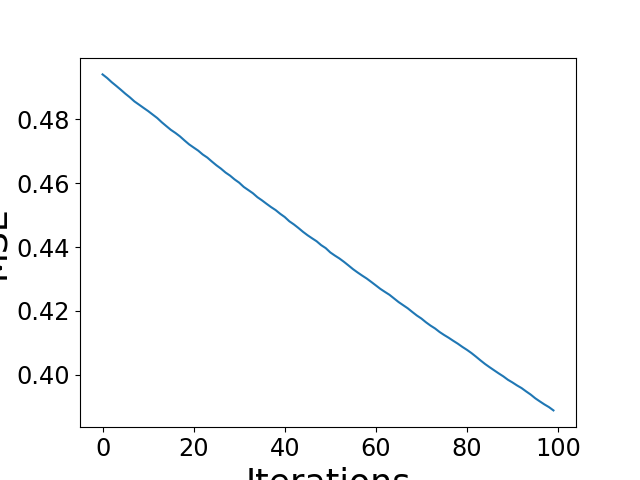

Text(0, 0.5, 'MSE')

In [16]:
import matplotlib.pyplot as plt
%matplotlib notebook
fig,ax = plt.subplots()

ax.plot(optim.mse_error)

ax.tick_params(labelsize='xx-large')

ax.set_xlabel("Iterations",fontsize=25)
ax.set_ylabel("MSE",fontsize=25)


# ax.legend(fontsize='large')

In [17]:
print(optim.parameter_history[-1])

[0.2964126  4.08195456 3.78327305]


In [18]:
yields= []
final_params=[]
mse_error = []
for i in range(len(optim.final_yields)):
    yields.append(optim.final_yields[i].item())
#     print(optim.final_solns[i].numpy())
    final_params.append(optim.final_solns[i].numpy())
    mse_error.append(optim.mse_error[i])
    
sort_indx=np.argsort(np.array(yields))
sorted_yields=np.array(yields)#[sort_indx]
sorted_params = np.array(final_params)#[sort_indx]
mse_error = np.array(mse_error)



print(list(sorted_params[-1]))


IndexError: index -1 is out of bounds for axis 0 with size 0

In [ ]:
print(len(optim.mse_error))

In [ ]:
yields= []
final_params=[]
mse_error = []

for i in range(len(optim.yield_per_iter)):
    yields.append(optim.yield_per_iter[i])
    params=[]
    for j in range(len(optim.parameter_history[i])):
        params.append(np.array(optim.parameter_history[i][j]))
    final_params.append(params)
    mse_error.append(optim.mse_error[i])
    
sorted_yields=np.array(yields)#[sort_indx]
sorted_params = np.array(final_params)#[sort_indx]
mse_error = np.array(mse_error)

print(sorted_params[-1])

In [ ]:
min_indx = np.argmin(mse_error)

min_rates = list(sorted_params[min_indx])
min_error = mse_error[min_indx]

# dG = -1*torch.log(min_rates[0][0]*vec_rn._C0/min_rates[1][0])
print("Params: ",min_rates)
# print("dG: ",dG)
print("Min SSE: ",min_error )

## Writing when koff is also a parameter

In [ ]:
# #Writing all solutions to a file

# klabels=['k'+str(i) for i in range(len(vec_rn.kon))]
# header = '#Yield\t' + "\t".join(klabels) + "\tt50\tt85\tt95\n"

# files_range = [str(f) for f in files_range]
# filestr = ",".join(files_range)


# with open("Solutions_Conc_Homorates_dGparam_07_part2",'a') as fl:
#     fl.write(header)
#     fl.write("# Range of Concentrations: %s\n" %filestr)
#     fl.write("# Learning rate: %s\n" %(",".join(str(lr) for lr in learn_rate)))
#     fl.write("# Momentum: %f\n" %(momentum))
#     fl.write("# Yield thresh: %f\n" %(yield_thresh))
#     for i in range(len(sorted_yields)):
#         fl.write("%f" %(sorted_yields[i]))
#         fl.write("\t%f" %(mse_error[i]))
#         for j in range((sorted_params[i].shape[0])):
#             for k in range(len(sorted_params[i][j])):
#                 fl.write("\t%f" %(sorted_params[i][j][k]))
#         fl.write("\n")
        
                 


### Writing outpout when only kon is parameter

In [ ]:
#Writing all solutions to a file

klabels=['k'+str(i) for i in range(len(vec_rn.kon))]
header = '#Yield\t' + "\t".join(klabels) + "\tt50\tt85\tt95\n"

files_range = [str(f) for f in files_range]
filestr = ",".join(files_range)


with open("Solutions_Conc_Homorates_dGNotrap_02_part1",'a') as fl:
    fl.write(header)
    fl.write("# Range of Concentrations: %s\n" %filestr)
    fl.write("# Learning rate: %s\n" %(str(learn_rate)))
    fl.write("# Momentum: %f\n" %(momentum))
    fl.write("# Yield thresh: %f\n" %(yield_thresh))
    for i in range(len(sorted_yields)):
        fl.write("%f" %(sorted_yields[i]))
        fl.write("\t%f" %(mse_error[i]))
        for j in range((sorted_params[i].shape[0])):
            fl.write("\t%f" %(sorted_params[i][j]))
        fl.write("\n")
                 


In [ ]:
fig,ax = plt.subplots()

k1=[]
for i in range(len(sorted_params)):
    k1.append(sorted_params[i][0])
ax.plot(k1)

In [ ]:
uid_dict = {}
sys.path.append("../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    #print(n)
    #print(rn.network.nodes()[n])
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_val = {'reactants':reactants,'kon':v['k_on'],'score':v['rxn_score'],'koff':v['k_off']}
        if uid not in uid_dict.keys():
            uid_dict[uid] = uid_val
    print(gtostr(rn.network.nodes[n]['struct']))
    #for r_set in rn.get_reactant_sets(n):
    #    print(tuple(r_set))
    #print(rn.network[n]['struct'])
ind_sort = np.argsort(vec_rn.kon.detach().numpy())
for i in ind_sort:
    print(vec_rn.kon[i])
    print(uid_dict[i])

In [ ]:
uid_dict = {}
sys.path.append("../")
import numpy as np
from reaction_network import gtostr
from torch import DoubleTensor as Tensor

def get_max_edge(n):
    """
    Calculates the max rate (k_on) for a given node
    To find out the maximum flow path to the final complex starting from the current node.
    
    Can also calculate the total rate of consumption of a node by summing up all rates. 
    Can tell which component is used quickly.
    """
    try:
        edges = rn.network.out_edges(n)
        #Loop over all edges
        #Get attributes
        if len(edges)==0:
            return(False)
        kon_max = -1
        next_node = -1
        
        kon_sum = 0
        for edge in edges:
            data = rn.network.get_edge_data(edge[0],edge[1])
            #print(data)
            #Get uid
            uid = data['uid']
            #Get updated kon
            temp_kon = vec_rn.kon[uid]
            kon_sum+=temp_kon
            
#             #Calculate k_off also
#             std_c = Tensor([1.])
#             l_kon = torch.log(temp_kon)
#             l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (self._R * self._T)) + l_kon + torch.log(std_c)
            if temp_kon > kon_max:
                kon_max = temp_kon
                next_node=edge[1]
        return(kon_max,next_node,kon_sum)
    except Exception as err:
        raise(err)

pathway = []
kon_sumarray = []
total_con_rate = {}
for n in rn.network.nodes():
    
    n_str = gtostr(rn.network.nodes[n]['struct']) 
    
    paths = [n_str]
    kon_sum = 0
    temp_node = n
    max_edge = True
    consumption_rate = 0
    if n < len(rn.network.nodes()):#num_monomers:
#         print("Current node: ")
#         print(n_str)
        while max_edge:
            max_edge = get_max_edge(temp_node)
            if max_edge:
                total_con_rate[gtostr(rn.network.nodes[temp_node]['struct'])] = max_edge[2]
                temp_node = max_edge[1]
                kon_sum += max_edge[0].item()
                
#                 print("Next node: ")
#                 print(temp_node)

                paths.append(gtostr(rn.network.nodes[temp_node]['struct']))
            else:
                break
        pathway.append(paths)
        kon_sumarray.append(kon_sum)
        paths=[]

print(pathway)
print(kon_sumarray)
#print(total_con_rate)

In [ ]:
for k,v in sorted(total_con_rate.items(),key=lambda x : x[1]):
    print(k," : ", v.item())

Let's first visualize some of the data.

**Without any optimization**


In [ ]:
nodes_list = ['A','B','S','M','AB','BMS','ABS','AMS','ABMS','AM','AS']
#nodes_list = ['A','B','ABMS']
optim.plot_observable(0,nodes_list)


**After 750 optimization iterations**


In [ ]:
optim.plot_observable(-1,nodes_list)


In [ ]:
optim.plot_yield()

It seems like we've found a stable solution that produces greater yield than equilibrium. This should be thermodynamically
impossible. Let's try to find an explanation. We'll run simulations using the learned optimal parameters at a few different
timescales.

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 3)
optim_rn = optim.rn
for i, runtime in enumerate([1, 8, 64]):
    optim_rn.reset()
    sim = VecSim(optim_rn, runtime, device='cpu')
    y = sim.simulate()
    sim.plot_observable(nodes_list,ax=ax[i],)
    ax[i].set_title("runtime: " + str(runtime) + " seconds")
fig.set_size_inches(18, 6)
node_map = {}
for node in rn.network.nodes():
    node_map[gtostr(rn.network.nodes[node]['struct'])] = node

print(node_map)
plt.show()

In [ ]:
node_map = {}
for node in rn.network.nodes():
    node_map[gtostr(rn.network.nodes[node]['struct'])] = node

print(node_map)
def get_max_edge(n):
    """
    Calculates the max rate (k_on) for a given node
    To find out the maximum flow path to the final complex starting from the current node.
    
    Can also calculate the total rate of consumption of a node by summing up all rates. 
    Can tell which component is used quickly.
    """
    try:
        edges = rn.network.out_edges(n)
        #Loop over all edges
        #Get attributes
        kon_max = -1
        next_node = -1

        kon_sum = 0
        total_flux_outedges = 0
        total_flux_inedges = 0
        if len(edges)==0:
            return(False)
            
        for edge in edges:
            data = rn.network.get_edge_data(edge[0],edge[1])
            #print(data)
            #Get uid
            uid = data['uid']

            #Get updated kon
            temp_kon = vec_rn.kon[uid]
            kon_sum+=temp_kon
            
            if temp_kon > kon_max:
                kon_max = temp_kon
                next_node=edge[1]
             
        return(kon_max,next_node,kon_sum)
    except Exception as err:
        raise(err)

        
def get_node_flux(n):
    total_flux_outedges = 0
    total_flux_inedges = 0
    #Go over all the out edges
    edges_out = rn.network.out_edges(n)
    if len(edges_out)>0:

        for edge in edges_out:
            data = rn.network.get_edge_data(edge[0],edge[1])
            #print(data)
            #Get uid
            uid = data['uid']

            #Get updated kon
            temp_kon = vec_rn.kon[uid]

            #Calculate k_off also
            std_c = Tensor([1.])
            l_kon = torch.log(temp_kon)
            l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
            koff = torch.exp(l_koff)

            #Getting conc. of reactants and products
            #Get product
            prod = gtostr(rn.network.nodes[edge[1]]['struct']) 
            #Get other reactant
            react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))

            #Net flux from this edge = Generation - consumption
            edge_flux = koff*vec_rn.copies_vec[edge[1]] - temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])
            #edge_flux = koff*vec_rn.copies_vec[edge[1]] 

            print("Reaction: ", gtostr(rn.network.nodes[edge[0]]['struct']), "+",react," -> ",prod)
            print("Net flux: ",edge_flux)
            print("kon : ",temp_kon)
            print("koff: ",koff)
            print("Reaction data OUTWARD: ")
            print(data)

            total_flux_outedges+=edge_flux
    
    #Now go over all the in edges
    edges_in = rn.network.in_edges(n)
    react_list = []
    if len(edges_in) > 0:
        for edge in edges_in:
            if edge[0] in react_list:
                continue
            data = rn.network.get_edge_data(edge[0],edge[1])
            uid = data['uid']


            #Get generation rates; which would be kon
            temp_kon = vec_rn.kon[uid]

            #Get consumption rates; which is k_off
            std_c = Tensor([1.])
            l_kon = torch.log(temp_kon)
            l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
            koff = torch.exp(l_koff)

            #Get conc. of reactants and products
            prod = gtostr(rn.network.nodes[edge[1]]['struct'])
            #Get other reactant
            react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))
            react_list.append(node_map[react])
            #Net flux from this edge = Generation - consumption
            edge_flux_in = temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])- koff*vec_rn.copies_vec[edge[1]]
            #edge_flux_in = koff*vec_rn.copies_vec[edge[1]]
            


            print("Reaction: ", prod ," -> ",gtostr(rn.network.nodes[edge[0]]['struct']), "+",react)
            print("Net flux: ",edge_flux_in)
            print("kon : ",temp_kon)
            print("koff: ",koff)
            print("Raction data INWARD: ")
            print(data)

            total_flux_inedges+=edge_flux_in
    net_node_flux = total_flux_outedges + total_flux_inedges
    
    return(net_node_flux)
    
pathway = []
kon_sumarray = []
total_con_rate = {}
net_flux = {}
for n in rn.network.nodes():
    
    n_str = gtostr(rn.network.nodes[n]['struct']) 
    
    paths = [n_str]
    kon_sum = 0
    temp_node = n
    max_edge = True
    consumption_rate = 0
    if n < len(rn.network.nodes()):#num_monomers:
#         print("Current node: ")
#         print(n_str)
        while max_edge:
            max_edge = get_max_edge(temp_node)
            if max_edge:
                total_con_rate[gtostr(rn.network.nodes[temp_node]['struct'])] = max_edge[2]
                
                temp_node = max_edge[1]
                kon_sum += max_edge[0].item()
                
                
#                 print("Next node: ")
#                 print(temp_node)

                paths.append(gtostr(rn.network.nodes[temp_node]['struct']))
            else:
                break
        pathway.append(paths)
        kon_sumarray.append(kon_sum)
        paths=[]
    print("-------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------")
    print("|                                                                             |")
    node_flux = get_node_flux(n)
    net_flux[gtostr(rn.network.nodes[n]['struct'])] = node_flux
    print("|                                                                             |")
    print("-------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------")

print(pathway)
print(kon_sumarray)

#print(total_con_rate)

In [ ]:
for k,v in sorted(net_flux.items(),key=lambda x : x[1]):
    print(k," : ", v)

print(vec_rn.copies_vec)
print(vec_rn.kon)

Clearly, the equilibrium reached by the system still matches the equilibrium solution. We have however found a set of parameters that can increase available complete AP2 at some point before equilibrium to levels significantly higher than at equilibrium. We don't observe any trapping, but have uncovered an interesting effect. 

Now we'll move on to looking at ARP23. This is 7 subunits, which drastically increases the number of possible reactions. Expect longer runtimes. 

In [ ]:
import torch.nn as nn

loss = nn.MSELoss()

bconc=Tensor([10,12,14,20,25])
b.requires_grad=True
a = Tensor([3,5,6,7,8,9,10])
a.requires_grad=True
b = Tensor([4,5,6,7,8])
b.requires_grad=True

c = a.expand(b.shape[0], a.shape[0])
c2 = b.expand(a.shape[0], b.shape[0])

d = torch.abs(c-c2.T)

print(d.shape)

indx = d.argmin(dim=1)

e = a[indx]
print(e)
f = 2*e

cost=loss(f,bconc)
print(cost)

cost.backward()
print(b)

In [ ]:
a = Tensor([0])
a.requires_grad=True
b = Tensor([10])
b.requires_grad=True

for i in range(10):
    a=torch.cat((a,b))
    
print(a)
